In [3]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import brier_score
from sksurv.util import Surv
from sklearn.model_selection import train_test_split

In [4]:
df_baseline = pd.read_csv("dataset/df_clean.csv")

df_baseline["Minutes of Use"] = df_baseline["Seconds of Use"] / 60
df_baseline["Charge Amount/10"] = df_baseline["Charge  Amount"] / 10
df_baseline = df_baseline.drop(columns=["Seconds of Use", "Charge  Amount"])

print(f"Shape: {df_baseline.shape}")
df_train, df_test = train_test_split(df_baseline, test_size=0.4, random_state=42)
print(f"Shape for training set: {df_train.shape}")
print(f"Shape for test set: {df_test.shape}")

Shape: (2850, 14)
Shape for training set: (1710, 14)
Shape for test set: (1140, 14)


In [5]:
y_train = df_train[["Subscription  Length", "Churn"]]

print("Baseline Target Structure: ")
print(y_train.head())

Baseline Target Structure: 
      Subscription  Length  Churn
1273                    29      0
888                     26      0
2783                    28      0
1517                    36      0
1672                    31      0


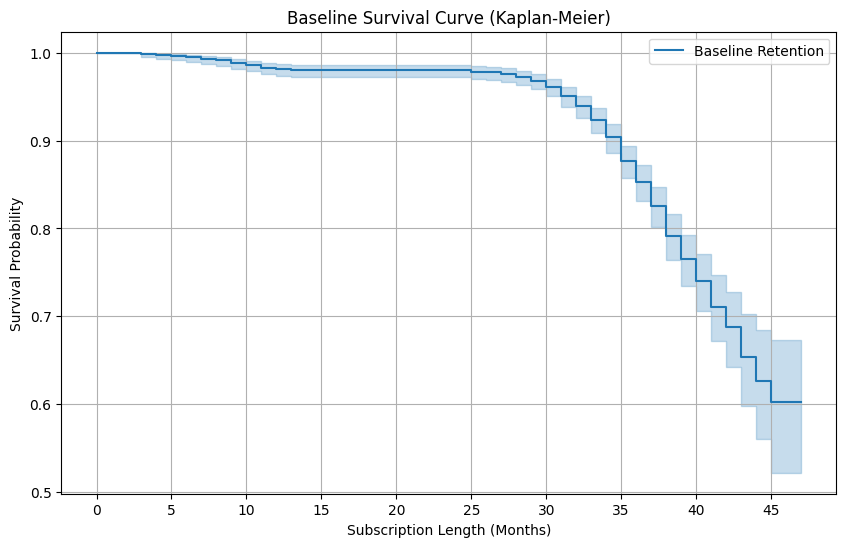

In [6]:
kmf = KaplanMeierFitter()

kmf.fit(durations=df_train["Subscription  Length"], event_observed=df_train["Churn"], label="Baseline Retention"
)


plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Baseline Survival Curve (Kaplan-Meier)')
plt.xlabel('Subscription Length (Months)')
plt.ylabel('Survival Probability')
plt.xticks(np.arange(0, df_train["Subscription  Length"].max()+1, 5))
plt.grid(True)
plt.show()

In [7]:
features = [
    "Call  Failure",
    "Complains",
    "Charge Amount/10",
    "Minutes of Use",
    "Frequency of SMS",
    "Distinct Called Numbers",
    "Age",
    "Tariff Plan"
]

target_data = ["Subscription  Length", "Churn"]
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train[features + target_data], duration_col="Subscription  Length", event_col="Churn")

c_index_external = cph.score(df_test[features + target_data], scoring_method="concordance_index")


                             coef  exp(coef)             p
covariate                                                 
Call  Failure            0.012535   1.012614  1.987240e-01
Complains                1.890302   6.621371  1.908552e-40
Charge Amount/10        -1.756379   0.172669  3.542357e-02
Minutes of Use          -0.010395   0.989659  1.456967e-06
Frequency of SMS        -0.005555   0.994461  4.901452e-06
Distinct Called Numbers -0.034914   0.965689  9.829279e-07
Age                     -0.017374   0.982776  3.353132e-02
Tariff Plan              0.539311   1.714825  2.247257e-01


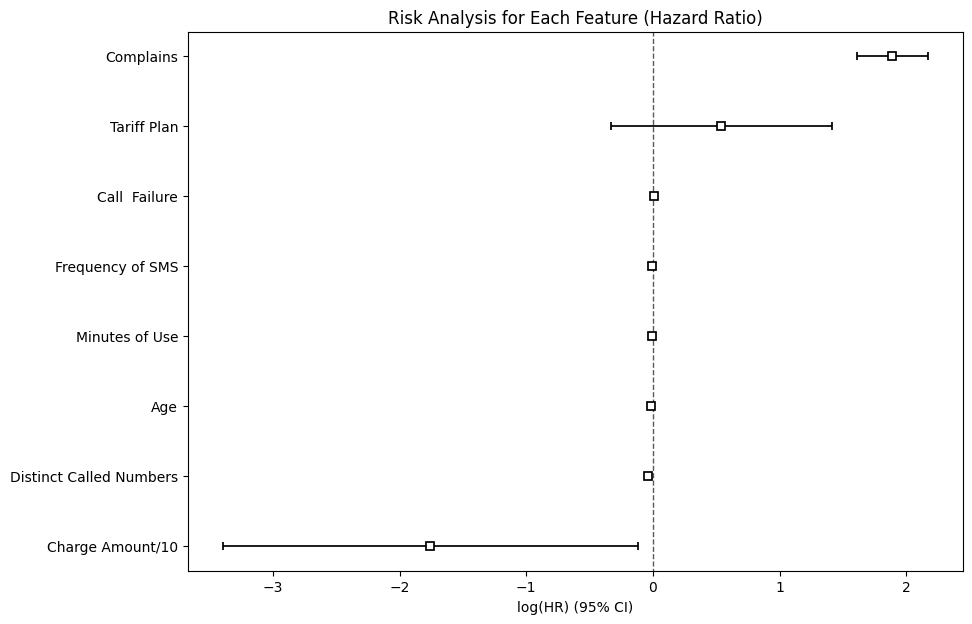

In [8]:
summary = cph.summary[["coef", "exp(coef)", "p"]]
print(summary)

plt.figure(figsize=(10, 7))
cph.plot()
plt.title("Risk Analysis for Each Feature (Hazard Ratio)")
plt.show()

In [9]:
print(f"C-Index Training: {cph.concordance_index_:.4f}")
print(f"C-Index Testing: {c_index_external:.4f}")

y_train = Surv.from_dataframe("Churn", "Subscription  Length", df_train)
y_test = Surv.from_dataframe("Churn", "Subscription  Length", df_test)

times = np.array([40])
pred_surv = cph.predict_survival_function(df_test, times=times)
surv_probs = pred_surv.values.T
times_val, score = brier_score(y_train, y_test, surv_probs, 40)

print(f"Brier Score at month 40: {score[0]:.4f}")

C-Index Training: 0.8735
C-Index Testing: 0.8738
Brier Score at month 40: 0.1691
